# Clasificación de Noticias Falsas con TF-IDF + Random Forest

Este notebook mejora el preprocesamiento para textos en español con eliminación de stopwords y tokenización eficiente.

In [1]:
import pandas as pd

# Carga de datos
ruta = "/content/Dataset_Completo.xlsx"
df = pd.read_excel(ruta)
df.head()


,Id,Category,Topic,Source,Headline,Text,Link
0,1,Fake,Education,El Ruinaversal,"RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR...","RAE INCLUIRÁ LA PALABRA ""LADY"" EN EL DICCIONAR...",http://www.elruinaversal.com/2017/06/10/rae-in...
1,2,Fake,Education,Hay noticia,"La palabra ""haiga"", aceptada por la RAE","La palabra ""haiga"", aceptada por la RAE La Rea...",https://haynoticia.es/la-palabra-haiga-aceptad...
2,3,Fake,Education,El Ruinaversal,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...,YORDI ROSADO ESCRIBIRÁ Y DISEÑARÁ LOS NUEVOS L...,http://www.elruinaversal.com/2018/05/06/yordi-...
3,4,True,Education,EL UNIVERSAL,UNAM capacitará a maestros para aprobar prueba...,UNAM capacitará a maestros para aprobar prueba...,http://www.eluniversal.com.mx/articulo/nacion/...
4,5,Fake,Education,Lamula,pretenden aprobar libros escolares con conteni...,Alerta: pretenden aprobar libros escolares con...,https://redaccion.lamula.pe/2018/06/19/memoria...


## Preprocesamiento con limpieza, tokenización y eliminación de stopwords

In [2]:
import re
from sklearn.feature_extraction import text

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Stopwords español
stopwords_es = set(stopwords.words('spanish'))

def limpiar_y_tokenizar(texto):
    texto = str(texto)
    texto = texto.lower()
    texto = re.sub(r"http\S+", "", texto)
    texto = re.sub(r"[^a-záéíóúñü\s]", "", texto)
    texto = re.sub(r"\s+", " ", texto).strip()
    tokens = texto.split()
    tokens = [t for t in tokens if t not in stopwords_es and len(t) > 2]
    tokens = [t for t in tokens if not t.isnumeric()]
    return " ".join(tokens)

# Combinar y limpiar. Inluimos en el campo texto_limpio la combinación de Topic, Source, Headline y Text
df["Headline"] = df["Headline"].fillna("")
df["Text"] = df["Text"].fillna("")
df["texto_limpio"] = (
    "Topic: " + df["Topic"] + ". " +
    "Source: " + df["Source"] + ". " +
    "Headline: " + df["Headline"] + " " +
    df["Text"]
).apply(limpiar_y_tokenizar)

df["Category"] = df["Category"].astype(str).str.strip().str.lower().map({"fake": 1, "true": 0})

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## División del conjunto de datos

In [3]:

from sklearn.model_selection import train_test_split

X = df["texto_limpio"]
y = df["Category"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


## Vectorización con TF-IDF

In [4]:

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words=list(stopwords_es)
)


X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


## Entrenamiento del modelo

In [5]:

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_vec, y_train)


RandomForestClassifier(random_state=42)

## Evaluación: Métricas, Matriz de Confusión y Curva ROC

Accuracy: 0.8770226537216829
F1-score: 0.87248322147651

Reporte de clasificación:
               precision    recall  f1-score   support

        Fake       0.86      0.90      0.88       156
        Real       0.90      0.85      0.87       153

    accuracy                           0.88       309
   macro avg       0.88      0.88      0.88       309
weighted avg       0.88      0.88      0.88       309



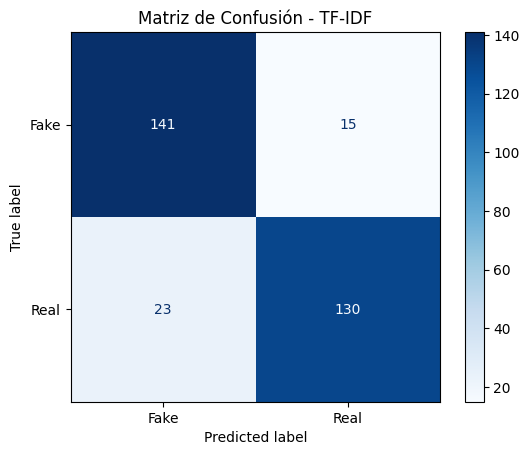

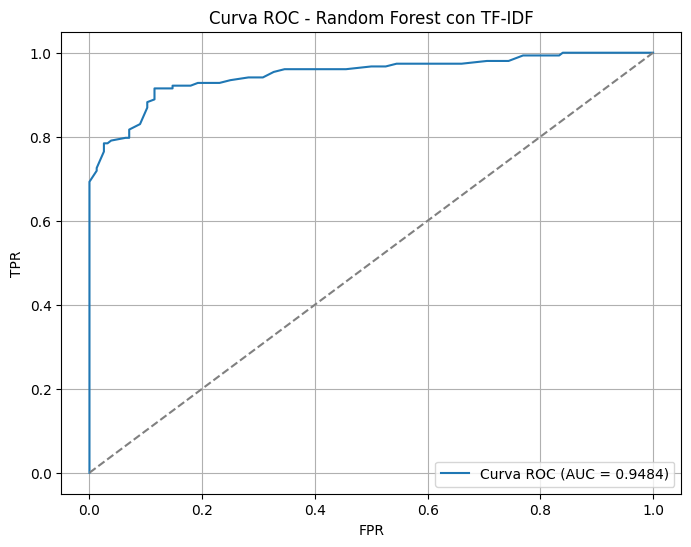

In [7]:

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd

# Predicciones y probabilidades
y_pred = clf.predict(X_test_vec)
y_pred_num = pd.Series(y_pred).map({0: 0, 1: 1})
y_proba = clf.predict_proba(X_test_vec)[:, 1]

# Métricas
print("Accuracy:", accuracy_score(y_test, y_pred_num))
print("F1-score:", f1_score(y_test, y_pred_num))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred_num, target_names=["Fake", "Real"]))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_num)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión - TF-IDF")
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Curva ROC (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC - Random Forest con TF-IDF")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Prueba con nuevas noticias

In [8]:
# Nuevas noticias a clasificar
nuevas_noticias = [
    "El pasado mes cuatro soldados resultaron heridos en Croacia cerca de un instituto nacional",
    "El presidente esta mañana en el Congreso anunció nuevas medidas ante la llegada de aliens."
]

# Usar la función mejorada de limpieza y tokenización
nuevas_limpias = [limpiar_y_tokenizar(n) for n in nuevas_noticias]
nuevas_vec = vectorizer.transform(nuevas_limpias)
predicciones = clf.predict(nuevas_vec)

# Mostrar resultados
for noticia, pred in zip(nuevas_noticias, predicciones):
    etiqueta = "Fake" if pred == 0 else "Real"
    print(f" {noticia}\n Predicción: {etiqueta}\n")


 El pasado mes cuatro soldados resultaron heridos en Croacia cerca de un instituto nacional
 Predicción: Fake

 El presidente esta mañana en el Congreso anunció nuevas medidas ante la llegada de aliens.
 Predicción: Real

